# **Discover and visualise the data to gain insights**

This notebook illustrates statistical inference and data analysis of the dataset CSECICIDS2018. Our goals will be the following:
1.	Check for imbalance.
2.	Check overall correlation.
3.	Check for missing values.
4.	Improve understanding of target variable and its relation to other variables.


## **Dataset preprocessing** 
Here we load the dataset as a dataframe with all the libraries that will be used in this notebook. 

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os
from scipy import stats
from scipy.stats import ks_2samp
%matplotlib inline

#directory path to piles
data_path = os.path.dirname(os.path.abspath('')) + "/data/combined/"
df = pd.read_pickle(data_path+'combined1.pickle')

### **Dealing with missing and infinity values**
The CSECICIDS2018 dataset has inf values which will induce an error in computation. Here, we transform all columns containing inf values to be treated as null values by Pandas.

In [21]:
pd.options.mode.use_inf_as_na = True
def missing_values_present(d):
    num = d.isnull().sum()
    den = d.count()
    return 100*(num/den)

print(missing_values_present(df).sort_values(ascending=False).head(3))


flow_pkts_s    0.593412
flow_byts_s    0.593412
dst_port       0.000000
dtype: float64


We have identified two columns, 'flow_pkts_s' and 'flow_byts_s'. 
The inf constants are treated as _null_, and subsequently we drop all null values. (Approximately 55k rows are dropped, <0.4% of total rows)

In [22]:
# print(df.shape[0]) #check of number of rows before dropping rows
df = df.dropna()
# print(df.shape[0]) #check of number of rows after dropping rows
# print(df.isnull().values.any()) # check for null after drop

### **Label investigation**

Next we investigate the label column to check the number of values present for cyber attacks and their distribution relative to eachother.

In [23]:
#Count of each label
print("Count of each label:\n",df['label'].value_counts())

#Distribution in of each label in percentage
print("Distribution of each label in percentage:\n", df['label'].value_counts(normalize=True))

Count of each label:
 Benign                      13390249
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: label, dtype: int64
Distribution of each label in percentage:
 Benign                      0.829776
DDOS attack-HOIC            0.042511
DDoS attacks-LOIC-HTTP      0.035706
DoS attacks-Hulk            0.028624
Bot                         0.017735
FTP-BruteForce              0.011982
SSH-Bruteforce              0.011625
Infilteration               0.009955
DoS attacks-SlowHTTPTest    0.008669
DoS attacks-GoldenEye

We can see, ~83% of traffic flows are 'Benign'. A clear indication of class imbalence. Next we change the label to a better read format by removing unwanted characters.

In [24]:
label_names = df['label'].unique()
label_names = [re.sub("[^a-zA-Z ]+", "", l) for l in label_names]
label_names = [re.sub("[\s\s]", '_', l) for l in label_names]
label_names = [lab.replace("__", "_") for lab in label_names]
label_names, len(label_names)

(['Benign',
  'Infilteration',
  'Bot',
  'DoS_attacksSlowHTTPTest',
  'DoS_attacksHulk',
  'DDoS_attacksLOICHTTP',
  'Brute_Force_Web',
  'Brute_Force_XSS',
  'SQL_Injection',
  'DoS_attacksGoldenEye',
  'DoS_attacksSlowloris',
  'DDOS_attackLOICUDP',
  'DDOS_attackHOIC',
  'FTPBruteForce',
  'SSHBruteforce'],
 15)

We then look to encode the labels, to do so we generate two extra columns to facilitate binary and muti-classifcation algorithms. The detect_threat column will identify if a row is a threat or benign. Whilst detect_type, will identify the type of threat.

In [25]:
df['label'] = df.label.astype('category')
df['detect_type'] = df['label'].cat.codes
df['detect_threat'] = df.label.apply(lambda x: 0 if x == 'Benign' else 1)

## **1. Simple binary analysis**

Plotting a simple graph for the binary classification shows that the dataset is drastically skewed towards benign threats.  

<AxesSubplot:xlabel='detect_threat', ylabel='count'>

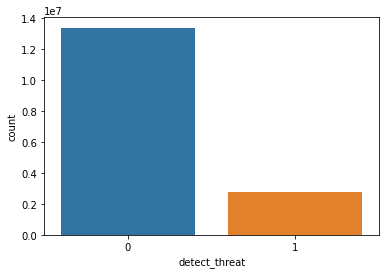

In [26]:
f, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='detect_threat', data=df, order = df['detect_threat'].value_counts().index, ax=ax)

Placing the graph into table format below for readibility

In [27]:
detect_threat = df.groupby('detect_threat').agg({'detect_threat':'first', 'detect_threat':'count'}).rename_axis(None).sort_values('detect_threat', ascending=False)
detect_threat['percentage'] = df['detect_threat'].value_counts(normalize=True)
detect_threat

,detect_threat,percentage
0,13390249,0.829776
1,2746934,0.170224


## **2. Simple multi-class analysis**

The next visual shows the flows of the distinct attack types. The graph illustrates an imbalance of the attack types in the following labels:
* DoS attacks-Slowloris
* DoS attacks-GoldenEye
* DDOS attack-LOIC-UDP
* SQL Injection
* Brute Force-XSS
* Brute Force-Web


<AxesSubplot:xlabel='count', ylabel='label'>

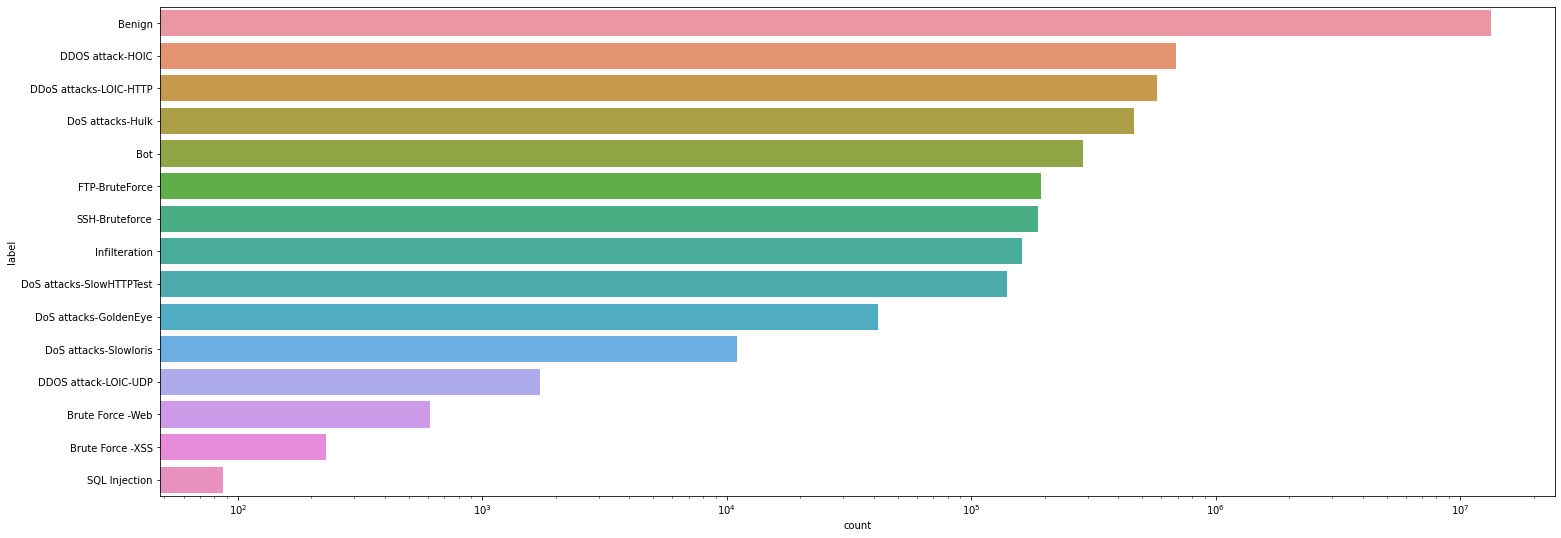

In [28]:
f, ax = plt.subplots(figsize=(25, 9))
ax.set(xscale='log')
sns.countplot(y='label', data=df, order = df['label'].value_counts().index, ax=ax)

Placing the graph into table format below for readibility

In [29]:
detect_type = df.groupby('label').agg({'label':'first', 'label':'count'}).rename_axis(None).sort_values('label', ascending=False)
detect_type['percentage'] = df['label'].value_counts(normalize=True)
detect_type

,label,percentage
Benign,13390249,0.829776
DDOS attack-HOIC,686012,0.042511
DDoS attacks-LOIC-HTTP,576191,0.035706
DoS attacks-Hulk,461912,0.028624
Bot,286191,0.017735
FTP-BruteForce,193354,0.011982
SSH-Bruteforce,187589,0.011625
Infilteration,160639,0.009955
DoS attacks-SlowHTTPTest,139890,0.008669
DoS attacks-GoldenEye,41508,0.002572


## **3. Correlation of the features**

Correlation is illustrated using a heat map, based on the overall correlation of the dataset. From examining this heatmap we can see there are a lot of strong correlations for several feature pairs. 

<AxesSubplot:>

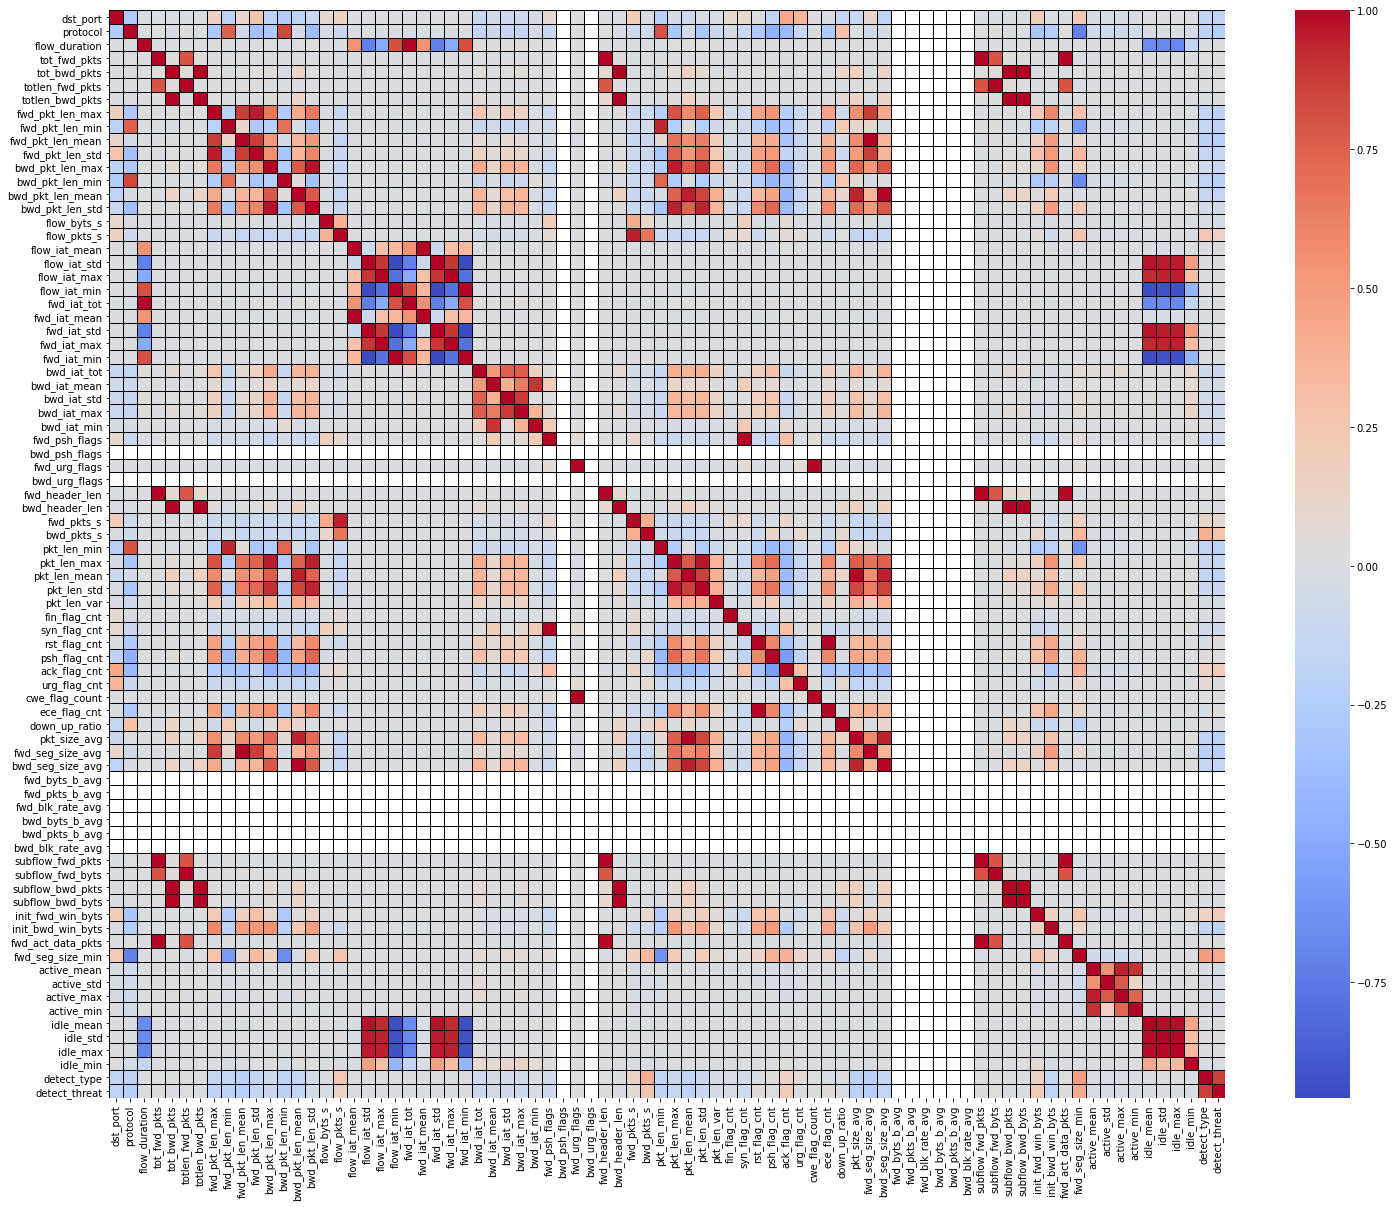

In [30]:
corr = df.drop(columns=['label', 'timestamp']).corr()
plt.figure(figsize=(25, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.6, cmap= 'coolwarm', linewidth=1, linecolor='black')

For increased readability, the features top 20 pairs with a strong correlation are listed in text format. These strong correlation are an indicator that some columns may be removed at a later date during feature engineering. 

In [31]:
   def top_correlation (df,n,corr):
    corr_matrix = corr
    correlation = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable_1","Variable_2","Correlation"]
    correlation = correlation.reindex(correlation.Correlation.abs().sort_values(ascending=False).index).reset_index().drop(["index"],axis=1)
    return correlation.head(n)

top_correlation(df,30, corr)

/tmp/ipykernel_3228/2282121947.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlation = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,Variable_1,Variable_2,Correlation
0,tot_fwd_pkts,subflow_fwd_pkts,1.000000
1,fwd_psh_flags,syn_flag_cnt,1.000000
2,totlen_fwd_pkts,subflow_fwd_byts,1.000000
3,fwd_pkt_len_mean,fwd_seg_size_avg,1.000000
4,tot_bwd_pkts,subflow_bwd_pkts,1.000000
5,fwd_urg_flags,cwe_flag_count,1.000000
6,bwd_pkt_len_mean,bwd_seg_size_avg,1.000000
7,totlen_bwd_pkts,subflow_bwd_byts,1.000000
8,flow_iat_min,fwd_iat_min,0.999996
9,flow_iat_max,fwd_iat_max,0.999994


## Summary
The visual analysis allowed us to understand the structure and make-up of the dataset, namely:

1. The relationship between malicious and benign traffic is greatly skewed towards benign traffic.
2. The magnitude of the different attacks are small when compared to eachother. This is an indication of a potential problem when we come to train a multi-classification method to identify these attacks correctly. 
3. There are many features strongly correlated, which signify that some of these features will be removed when executing feature selection.


In [33]:
output_data_path = os.path.dirname(os.path.abspath('')) + "/data/combined/"
df.to_pickle(output_data_path+'combined_cleaned.pickle')